# Use LSTM To Predict Rent

Since pairs require predictions for each SA2 region, this chapter is roughly divided into two parts,
- The first part uses a certain SA2 as an example to make a prediction
- The second part is to sort all SA2 after prediction




In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from statsmodels.tsa.ar_model import AutoReg

import tensorflow as tf
from tensorflow.keras import Sequential, layers, utils, losses
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard


import warnings
warnings.filterwarnings('ignore')

# single SA2 predict

This part is mainly composed of the following steps
1. Load Dataset And Show Base Info
2. Data visualization
3. Feature Engineering
4. Model Predict

## 1. Load Dataset And Show Base Info

In [67]:
# load dataset
dataset = pd.read_csv(r"../data/curated/history_info.csv", index_col=0)

Since we need to predict the growth rate, we need to convert the house price into a growth rate first

In [68]:
# convert median_rent to growth_rate
dataset['growth_rate'] = dataset.groupby('SA2')["median_rent"].apply(pd.Series.pct_change)

In [69]:
# Since we want to make predictions for each SA2 region, we take out a SA2 region for analysis
# Take 202011022 area as an example
single_dataset = dataset[dataset["SA2"] == 201011001].reset_index(drop=True)

In [70]:
# The first 5 columns are shown here to see their basic information
single_dataset.head()

,SA2,year,quarter,population,bond,price_index,deal_count,median_rent,to_USD,immi_count,debt_ratio,growth_rate
0,201011001,2013,3,9550,2.90,105.0,1027,280.0,0.9309,121500,0.85875,NaN
1,201011001,2013,4,9714,2.96,109.0,1050,290.0,0.8948,122250,0.86000,0.035714
2,201011001,2014,1,9870,2.97,110.0,1251,295.0,0.9221,123730,0.85875,0.017241
3,201011001,2014,2,10026,2.80,112.0,1069,280.0,0.9420,125210,0.85750,-0.050847
4,201011001,2014,3,10182,2.80,113.0,1035,300.0,0.8752,126690,0.85625,0.071429


We can see that each piece of data is recorded in the dimensions of year and quarter

and the features are
- population 
- bond
- price_index
- deal_count 
- to_USD       
- immi_count
- debt_ratio

label为：
- growth_rate


In [71]:
# dataset info
single_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SA2          26 non-null     int64  
 1   year         26 non-null     int64  
 2   quarter      26 non-null     int64  
 3   population   26 non-null     int64  
 4   bond         26 non-null     float64
 5   price_index  26 non-null     float64
 6   deal_count   26 non-null     int64  
 7   median_rent  26 non-null     float64
 8   to_USD       26 non-null     float64
 9   immi_count   26 non-null     int64  
 10  debt_ratio   26 non-null     float64
 11  growth_rate  25 non-null     float64
dtypes: float64(6), int64(6)
memory usage: 2.6 KB


From here we can see that there are 26 history data 202011022 this SA2</br>
From Non-Null Count you can see that there are no missing values

In [72]:
# Give a description of the dataset
single_dataset.describe()

,SA2,year,quarter,population,bond,price_index,deal_count,median_rent,to_USD,immi_count,debt_ratio,growth_rate
count,26.0,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,25.000000
mean,201011001.0,2016.230769,2.576923,11823.115385,1.989231,132.269231,1094.461538,313.769231,0.775373,147449.923077,0.998606,0.009408
std,0.0,1.924738,1.137474,1498.369843,0.593316,15.953828,89.850645,23.507544,0.076521,16115.036749,0.134500,0.030465
min,201011001.0,2013.000000,1.000000,9550.000000,0.770000,105.000000,941.000000,280.000000,0.674900,121500.000000,0.850000,-0.050847
25%,201011001.0,2015.000000,2.000000,10556.750000,1.777500,116.250000,1030.500000,296.000000,0.722550,131935.250000,0.857812,-0.013378
50%,201011001.0,2016.000000,3.000000,11750.000000,2.010000,134.500000,1079.000000,309.500000,0.763900,152703.500000,0.994375,0.013115
75%,201011001.0,2018.000000,3.750000,13024.000000,2.122500,147.000000,1171.250000,330.625000,0.782925,160688.750000,1.134062,0.028986
max,201011001.0,2019.000000,4.000000,14408.000000,2.970000,154.000000,1275.000000,357.500000,0.942000,168310.000000,1.180000,0.071429


As you can see from the variance, bond, to_USD, debt_ratio the variance of these features is small, so the degree of differentiation is small

## 2. Data visualization

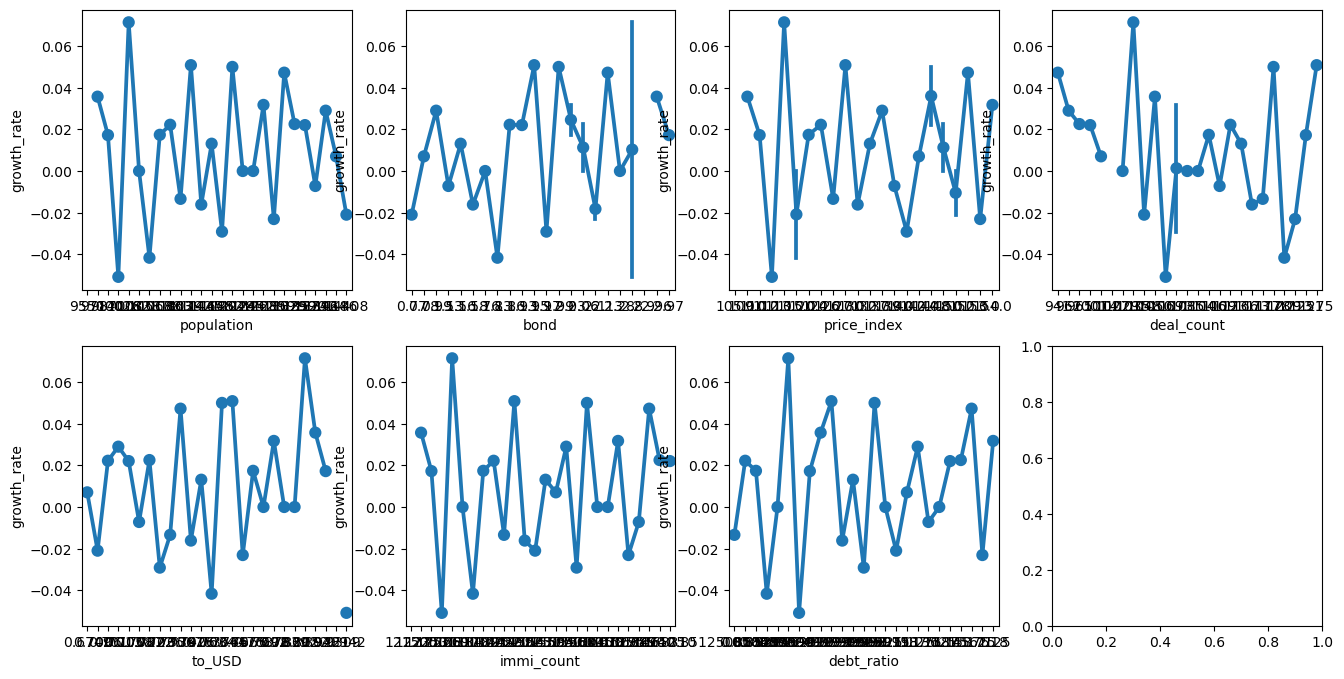

In [73]:
fig, axes = plt.subplots(2,4, figsize=(16,8))
sns.pointplot(x='population', y='growth_rate', data=single_dataset, ax=axes[0][0])
sns.pointplot(x='bond', y='growth_rate', data=single_dataset, ax=axes[0][1])
sns.pointplot(x='price_index', y='growth_rate', data=single_dataset, ax=axes[0][2])
sns.pointplot(x='deal_count', y='growth_rate', data=single_dataset, ax=axes[0][3])
sns.pointplot(x='to_USD', y='growth_rate', data=single_dataset, ax=axes[1][0])
sns.pointplot(x='immi_count', y='growth_rate', data=single_dataset, ax=axes[1][1])
sns.pointplot(x='debt_ratio', y='growth_rate', data=single_dataset, ax=axes[1][2])
plt.show()

Here is a simple analysis of the relationship between each feature and the label, which is roughly the trend of fluctuations within a certain range

## 3. Feature Engineering

There are several main difficulties in predicting the future:
- How to get future features
- How to predict house prices

For the above problems, we use the following solutions after discussion:
- How to get future features
  
  The autoregressive method area is used to predict future features
- How to predict house prices
  
  The LSTM zone is used to forecast the growth rate
  

In [74]:
# year and quarter merge to time
single_dataset['year'] = single_dataset['year'].astype('str')
single_dataset['quarter'] = single_dataset['quarter'].astype('str')

single_dataset['time'] = single_dataset["year"] +'_'+ single_dataset["quarter"]

In [75]:
# fill na
single_dataset.dropna(inplace=True)
# Since only the fourth quarter of 2013 is left, it is not used directly, 
# drop 2013
single_dataset = single_dataset[single_dataset['year']!= '2013'].reset_index(drop=True)

### Use AR Model to get future feature

Get future feature data

In [11]:
columns = ['population', 'bond', 'price_index', 'deal_count', 'to_USD', 
           'immi_count', 'debt_ratio']
ext_time = pd.Series([f"{y}_{q}" for y in range(2020, 2024) for q in range(1,5)],index=range(24,40))

In [76]:
def AR_model_predict(df,feature):
    data_len = len(df[feature])
    AR2_model = AutoReg(df[feature], 4).fit()  
    # predict
    predict = AR2_model.predict(data_len, len(single_dataset)+15)
    return predict

In [13]:
data_list = []
for col in columns:
    data_list.append(AR_model_predict(single_dataset, col))
data_list.append(ext_time)

In [14]:
for_predict = pd.concat(data_list, axis=1).reset_index(drop=True)

In [15]:
ext_columns = columns + ['time']
for_predict.columns = ext_columns

deal training and test sets

In [16]:
# drop unused cols
single_dataset.drop(columns=['SA2','year','quarter','median_rent'], axis=1, inplace=True)

In [17]:
single_dataset.set_index(keys='time', inplace=True)
for_predict.set_index(keys='time', inplace=True)

Standardize on datasets

In [18]:
for col in columns:
    scaler = MinMaxScaler()
    single_dataset[col] = scaler.fit_transform(single_dataset[col].values.reshape(-1,1))
    for_predict[col] = scaler.fit_transform(for_predict[col].values.reshape(-1,1))

In [19]:
single_dataset.head()

,population,bond,price_index,deal_count,to_USD,immi_count,debt_ratio,growth_rate
time,,,,,,,,
2014_1,0.000000,1.000000,0.000000,0.928144,0.925496,0.000000,0.026515,0.017241
2014_2,0.034376,0.922727,0.045455,0.383234,1.000000,0.033199,0.022727,-0.050847
2014_3,0.068753,0.922727,0.068182,0.281437,0.749906,0.066397,0.018939,0.071429
2014_4,0.103129,0.686364,0.113636,0.488024,0.543991,0.099596,0.015152,0.000000
2015_1,0.141692,0.481818,0.113636,0.802395,0.331337,0.167160,0.011364,-0.041667


In [20]:
# set feature and label
X = single_dataset.drop(columns=['growth_rate'], axis=1)

y = single_dataset['growth_rate']

In [21]:
X.shape

(24, 7)

In [22]:
# split data： X_train, X_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=666)
# X_train, y_train = X, y

In [23]:
X_train.shape

(19, 7)

In [24]:
y_train.shape

(19,)

In [25]:
X_train.head()

,population,bond,price_index,deal_count,to_USD,immi_count,debt_ratio
time,,,,,,,
2014_1,0.000000,1.000000,0.000000,0.928144,0.925496,0.000000,0.026515
2014_2,0.034376,0.922727,0.045455,0.383234,1.000000,0.033199,0.022727
2014_3,0.068753,0.922727,0.068182,0.281437,0.749906,0.066397,0.018939
2014_4,0.103129,0.686364,0.113636,0.488024,0.543991,0.099596,0.015152
2015_1,0.141692,0.481818,0.113636,0.802395,0.331337,0.167160,0.011364


In [77]:
# Construct a feature dataset
def create_dataset(X, y, seq_len=2):
    features = []
    targets = []
    for i in range(0, len(X) - seq_len):
        data = X.iloc[i:i+seq_len] 
        label = y.iloc[i+seq_len]
        # save features and labels
        features.append(data)
        targets.append(label)
    return np.array(features), np.array(targets)

In [27]:
def create_fea_dataset(X, seq_len=2):
    features = []
    for i in range(0, len(X) - seq_len):
        data = X.iloc[i:i+seq_len]
        features.append(data)
    return np.array(features)

In [28]:

# set step size 2
train_dataset, train_labels = create_dataset(X_train, y_train, seq_len=2)

In [29]:
predict_data = create_fea_dataset(for_predict,seq_len=2)

In [30]:
train_dataset.shape

(17, 2, 7)

In [31]:
train_labels.shape

(17,)

In [32]:

test_dataset, test_labels = create_dataset(X_test, y_test, seq_len=2)

In [78]:
# Construct batch data methods to improve performance

def create_batch_dataset(X, y, train=True, buffer_size=1000, batch_size=128):
    batch_data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    if train:
        return batch_data.cache().shuffle(buffer_size).batch(batch_size)
    else:
        return batch_data.batch(batch_size)

In [34]:
train_batch_dataset = create_batch_dataset(train_dataset, train_labels)
test_batch_dataset = create_batch_dataset(test_dataset, test_labels, train=False)

In [36]:
# From the train batch data, obtain a sample data of batch_size
list(train_batch_dataset.as_numpy_iterator())[0]

(array([[[0.10312913, 0.68636364, 0.11363636, 0.48802395, 0.54399101,
          0.09959623, 0.01515152],
         [0.14169238, 0.48181818, 0.11363636, 0.80239521, 0.33133658,
          0.16716016, 0.01136364]],
 
        [[0.6101807 , 0.57272727, 1.        , 0.39520958, 0.39348559,
          0.83983849, 1.        ],
         [0.6586602 , 0.60454545, 0.97727273, 0.81437126, 0.34294272,
          0.87987887, 0.97348485]],
 
        [[0.18025562, 0.57272727, 0.22727273, 0.49401198, 0.34855859,
          0.23474652, 0.00757576],
         [0.21881886, 0.49545455, 0.31818182, 0.54491018, 0.09771621,
          0.30231045, 0.00378788]],
 
        [[0.5667695 , 0.58636364, 0.90909091, 0.26347305, 0.40808686,
          0.83120233, 0.875     ],
         [0.6101807 , 0.57272727, 1.        , 0.39520958, 0.39348559,
          0.83983849, 1.        ]],
 
        [[0.30233583, 0.53636364, 0.38636364, 1.        , 0.33994759,
          0.47873486, 0.125     ],
         [0.34706919, 0.36818182, 0.4545454

## 4. Model Predict

In [37]:
# Model building
model = Sequential([
    layers.LSTM(units=16, input_shape=train_dataset.shape[-2:], return_sequences=True),
    #layers.Dropout(0.4),
    layers.LSTM(units=4, return_sequences=True),
    layers.Dense(1),
])

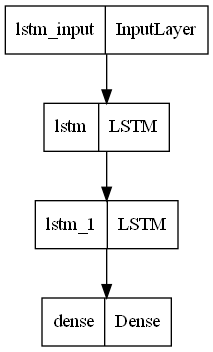

In [38]:
# Displays the model structure
utils.plot_model(model)

In [39]:
# model compile
model.compile(optimizer='adam',
              loss='mse')

In [40]:
# Save the model weights file and training log
log_file = r'../models/logs/'
tensorboard_callback = TensorBoard(log_file)

In [41]:
checkpoint_file = "best_model.hdf5"

checkpoint_callback = ModelCheckpoint(filepath=checkpoint_file, 
                                      monitor='loss',
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only=True)

In [42]:
# training
history = model.fit(train_batch_dataset,
                    epochs=5,
                    validation_data=test_batch_dataset,
                    callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.0013 - val_loss: 0.0012
Epoch 2/5
1/1 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 3/5
1/1 [==============================] - 0s 31ms/step - loss: 0.0012 - val_loss: 8.5269e-04
Epoch 4/5
1/1 [==============================] - 0s 39ms/step - loss: 0.0012 - val_loss: 7.4920e-04
Epoch 5/5
1/1 [==============================] - 0s 22ms/step - loss: 0.0012 - val_loss: 6.8068e-04


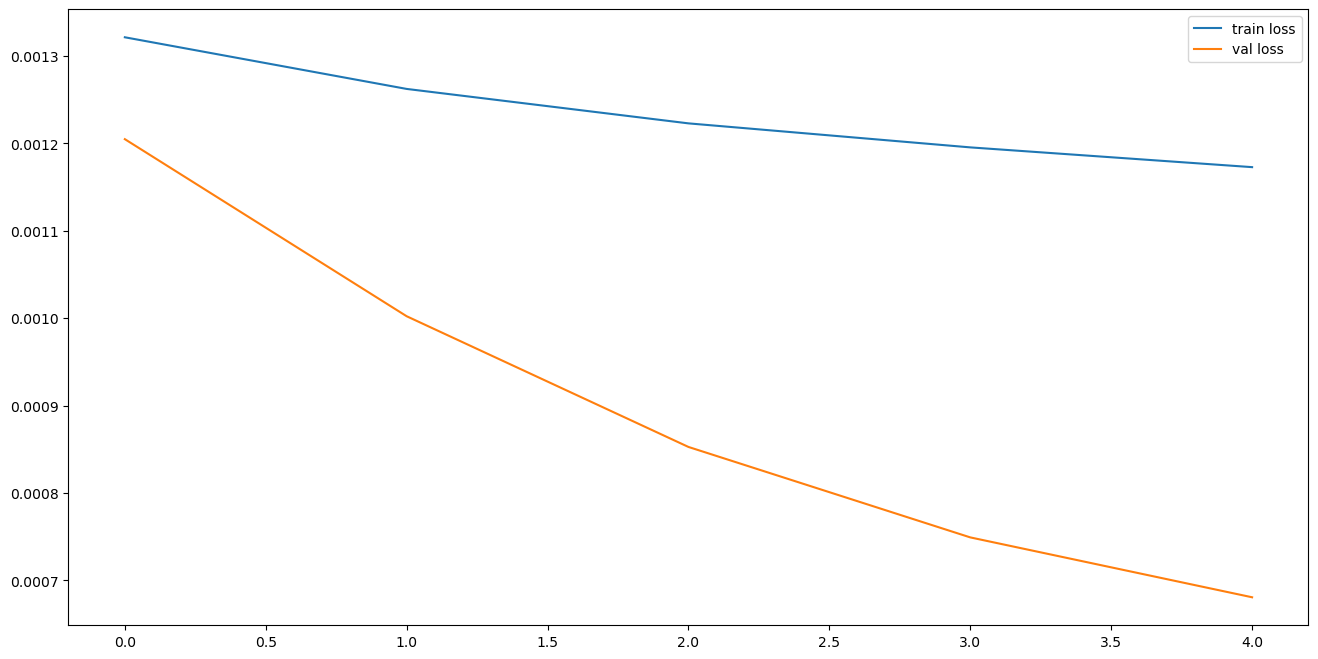

In [43]:
# Displays the training results
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend(loc='best')
plt.show()

In [44]:
predict_data.shape

(14, 2, 7)

In [45]:
test_preds = model.predict(predict_data, verbose=1)

1/1 [==============================] - 1s 520ms/step


In [46]:
test_preds_list = test_preds[:, 0]
# get 2023 year  predict
test_preds_list[-1][0]

0.011418503

# All SA2 Predict

Forecast all SA2 regions</br>
Here is the forecast for the growth rate in 2023

In [47]:
def growth_rate_predict(df):
    # year and quarter merge to time
    df['year'] = df['year'].astype('str')
    df['quarter'] = df['quarter'].astype('str')
    df['time'] = df["year"] +'_'+ df["quarter"]
    
    # fill na
    df.dropna(inplace=True)
    # drop 2013
    df = df[df['year']!= '2013'].reset_index(drop=True)
    
    # get future feature 
    data_list = []
    for col in columns:
        data_list.append(AR_model_predict(df, col))
    data_list.append(ext_time)
    for_predict = pd.concat(data_list, axis=1).reset_index(drop=True)
    ext_columns = columns + ['time']
    for_predict.columns = ext_columns
    
    # drop unused cols
    df.drop(columns=['SA2','year','quarter','median_rent'], axis=1, inplace=True)
    
    # set index
    df.set_index(keys='time', inplace=True)
    for_predict.set_index(keys='time', inplace=True)
    
    # MinMaxScaler
    for col in columns:
        scaler = MinMaxScaler()
        df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))
        for_predict[col] = scaler.fit_transform(for_predict[col].values.reshape(-1,1))
    
    # set feature and label
    X = df.drop(columns=['growth_rate'], axis=1)
    y = df['growth_rate']
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=666)
    
    train_dataset, train_labels = create_dataset(X_train, y_train, seq_len=2)
    predict_data = create_fea_dataset(for_predict,seq_len=2)
    test_dataset, test_labels = create_dataset(X_test, y_test, seq_len=2)
    

    train_batch_dataset = create_batch_dataset(train_dataset, train_labels)
    test_batch_dataset = create_batch_dataset(test_dataset, test_labels, train=False)


    model = Sequential([
        layers.LSTM(units=16, input_shape=train_dataset.shape[-2:], return_sequences=True),
        #layers.Dropout(0.4),
        layers.LSTM(units=4, return_sequences=True),
        layers.Dense(1),
    ])

    model.compile(optimizer='adam', loss='mse')

    history = model.fit(train_batch_dataset,
                        epochs=3,
                        validation_data=test_batch_dataset)
    
    test_preds = model.predict(predict_data, verbose=0)
    test_preds_list = test_preds[:, 0]
    # get 2023 year  predict
    final_predict = test_preds_list[-1][0]
    return final_predict

In [48]:
predict_data = dataset.groupby("SA2").apply(growth_rate_predict)

Epoch 1/3
1/1 [==============================] - 3s 3s/step - loss: 0.0012 - val_loss: 7.8970e-04
Epoch 2/3
1/1 [==============================] - 0s 12ms/step - loss: 0.0012 - val_loss: 6.3109e-04
Epoch 3/3
1/1 [==============================] - 0s 13ms/step - loss: 0.0011 - val_loss: 5.5089e-04
Epoch 1/3
1/1 [==============================] - 3s 3s/step - loss: 4.8693e-04 - val_loss: 3.7984e-04
Epoch 2/3
1/1 [==============================] - 0s 1ms/step - loss: 4.3894e-04 - val_loss: 3.3079e-04
Epoch 3/3
1/1 [==============================] - 0s 16ms/step - loss: 4.0438e-04 - val_loss: 3.0998e-04
Epoch 1/3
1/1 [==============================] - 3s 3s/step - loss: 0.0028 - val_loss: 0.0057
Epoch 2/3
1/1 [==============================] - 0s 11ms/step - loss: 0.0025 - val_loss: 0.0050
Epoch 3/3
1/1 [==============================] - 0s 12ms/step - loss: 0.0021 - val_loss: 0.0042
Epoch 1/3
1/1 [==============================] - 3s 3s/step - loss: 0.0015 - val_loss: 0.0018
Epoch 2/3
1/1

In [ ]:
match_df = pd.read_csv(f"../data/raw/ABS/SA2_TO_Name.csv")
match_df = match_df[["code", "name"]]

predict_data = predict_data.reset_index()
predict_data = pd.merge(match_df, predict_data, left_on="code", right_on="SA2", how="right")
predict_data = predict_data.set_index("name").drop(["index"], axis=1)

sort_predict = predict_data.sort_values(ascending=False, inplace=False)

top_10 = list(sort_predict.index)[:10]

In [49]:
predict_data

SA2
201011001    0.008092
201011002    0.017625
201011005    0.048293
201011006   -0.011180
201011007    0.003971
               ...   
217031476   -0.012929
217041477   -0.013567
217041478   -0.013845
217041479    0.038731
217041480    0.012843
Length: 501, dtype: float32

In [54]:
sort_predict = predict_data.sort_values(ascending=False, inplace=False)

In [57]:
top_10 = list(sort_predict.index)[:10]

In [61]:
sort_predict[:10]

SA2
210031237    0.076467
207011147    0.059952
213051464    0.056824
212031559    0.054760
207011149    0.049069
205021083    0.048547
201011005    0.048293
201011484    0.045643
203011034    0.044331
204021064    0.044223
dtype: float32

In [60]:
print(f"the top 10 growth_rate SA2 is \n{top_10}")

the top 10 growth_rate SA2 is 
[210031237, 207011147, 213051464, 212031559, 207011149, 205021083, 201011005, 201011484, 203011034, 204021064]
